In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,cross_val_score,learning_curve,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,IsolationForest,RandomForestRegressor,AdaBoostClassifier,VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor,KNeighborsClassifier
from sklearn.decomposition import PCA  
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

In [52]:
ml_data = pd.read_csv('hcvdat0.csv')
ml_data.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [53]:
# Removing Unnamed:0 , as it an unnecssary index column from the csvfile
ml_data.drop(['Unnamed: 0'], axis=1 ,inplace=True)

In [54]:
# Convert Category
ml_data['Category'] = ml_data['Category'].map({
    '0=Blood Donor': 0,
    '0s=suspect Blood Donor': 0,
    '1=Hepatitis': 1,
    '2=Fibrosis': 2,
    '3=Cirrhosis': 3
}).astype(int)

#Convert Sex
ml_data.Sex = ml_data.Sex.apply(lambda x: 0 if x == 'm' else 1)

In [55]:
ml_data.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

In [56]:
ml_data['ALB'] = ml_data['ALB'].fillna(ml_data.groupby('Category')['ALB'].transform('mean'))
ml_data['ALP'] = ml_data['ALP'].fillna(ml_data.groupby('Category')['ALP'].transform('mean'))
ml_data['ALT'] = ml_data['ALT'].fillna(ml_data.groupby('Category')['ALT'].transform('mean'))
ml_data['CHOL'] = ml_data['CHOL'].fillna(ml_data.groupby('Category')['CHOL'].transform('mean'))
ml_data['PROT'] = ml_data['PROT'].fillna(ml_data.groupby('Category')['PROT'].transform('mean'))

In [57]:
ml_data.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

In [59]:
num_of_category = ml_data.Category.value_counts()
num_of_category

0    540
3     30
1     24
2     21
Name: Category, dtype: int64

In [60]:
data_without_categories = ml_data[['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']]
labels = ml_data[['Category']]

In [62]:
from sklearn.utils import resample

# Example data (replace with actual dataset and category labels)
X = data_without_categories  # Your feature matrix
y = labels  # Your target labels (5 categories)

# Combine features and labels into a single DataFrame (for convenience)
data = np.column_stack((X, y))

# Identify the majority and minority classes
majority_class = data[data[:, -1] == 0]  # Replace '0' with your majority class label
minority_classes = [data[data[:, -1] == label] for label in np.unique(y) if label != 0]  # For the other categories

# Oversample each minority class to match the size of the majority class
oversampled_minority_classes = [resample(minority_class, 
                                         replace=True,         # Sample with replacement
                                         n_samples=len(majority_class),  # Match majority class size
                                         random_state=42)  # For reproducibility
                               for minority_class in minority_classes]

# Combine the majority class and oversampled minority classes back together
oversampled_data = np.vstack([majority_class] + oversampled_minority_classes)

# Separate the features and labels again
X_oversampled = oversampled_data[:, :-1]
y_oversampled = oversampled_data[:, -1]

# Now, you can apply your unsupervised clustering model (e.g., KMeans)


In [63]:
# Create oversampled datframe with Labels
oversampled_df = pd.DataFrame(oversampled_data, columns=['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT', 'Category'])
print(oversampled_df)

       Age  Sex   ALB    ALP   ALT    AST    BIL    CHE  CHOL   CREA    GGT  \
0     32.0  0.0  38.5   52.5   7.7   22.1    7.5   6.93  3.23  106.0   12.1   
1     32.0  0.0  38.5   70.3  18.0   24.7    3.9  11.17  4.80   74.0   15.6   
2     32.0  0.0  46.9   74.7  36.2   52.6    6.1   8.84  5.20   86.0   33.2   
3     32.0  0.0  43.2   52.0  30.6   22.6   18.9   7.33  4.74   80.0   33.8   
4     32.0  0.0  39.2   74.1  32.6   24.8    9.6   9.15  4.32   76.0   29.9   
...    ...  ...   ...    ...   ...    ...    ...    ...   ...    ...    ...   
2155  62.0  1.0  32.0  416.6   5.9  110.3   50.0   5.57  6.30   55.7  650.9   
2156  62.0  1.0  32.0  416.6   5.9  110.3   50.0   5.57  6.30   55.7  650.9   
2157  49.0  1.0  33.0  190.7   1.2   36.3    7.0   6.92  3.82  485.9  112.0   
2158  59.0  0.0  31.0   86.3   5.4   95.4  117.0   1.57  3.51   60.5   53.6   
2159  74.0  0.0  23.0   34.1   2.1   90.4   22.0   2.50  3.29   51.0   46.8   

      PROT  Category  
0     69.0       0.0  
1    

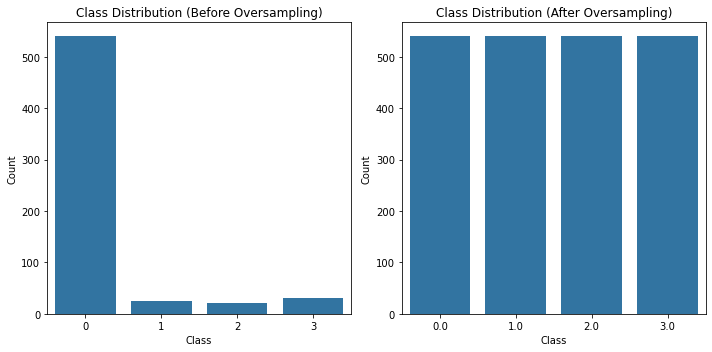

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Count original class distribution
unique_classes, counts_before = np.unique(y, return_counts=True)
unique_classes_after, counts_after = np.unique(y_oversampled, return_counts=True)

plt.figure(figsize=(10, 5))

# Before oversampling
plt.subplot(1, 2, 1)
sns.barplot(x=unique_classes, y=counts_before)
plt.title("Class Distribution (Before Oversampling)")
plt.xlabel("Class")
plt.ylabel("Count")

# After oversampling
plt.subplot(1, 2, 2)
sns.barplot(x=unique_classes_after, y=counts_after)
plt.title("Class Distribution (After Oversampling)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


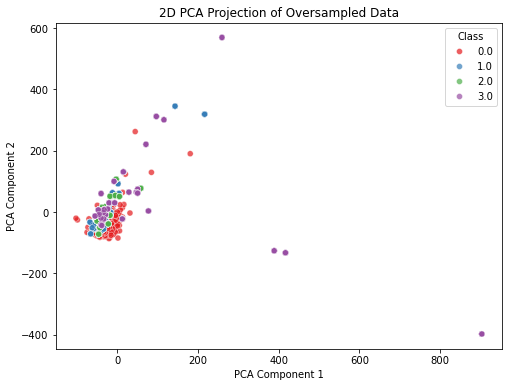

In [65]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_oversampled)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_oversampled, palette="Set1", alpha=0.7)
plt.title("2D PCA Projection of Oversampled Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Class")
plt.show()

In [66]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(X_oversampled)

scaled_df = pd.DataFrame(scaled_data, columns=['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT'])
print(scaled_df)

           Age  Sex     ALB       ALP       ALT       AST        BIL  \
0    -0.894737  0.0 -0.3125  0.148208 -0.385852 -0.414010  -0.436893   
1    -0.894737  0.0 -0.3125  0.580684 -0.054662 -0.373081  -0.786408   
2    -0.894737  0.0  0.7375  0.687589  0.530547  0.066116  -0.572816   
3    -0.894737  0.0  0.2750  0.136060  0.350482 -0.406139   0.669903   
4    -0.894737  0.0 -0.2250  0.673011  0.414791 -0.371507  -0.233010   
...        ...  ...     ...       ...       ...       ...        ...   
2155  0.684211  1.0 -1.1250  8.994533 -0.443730  0.974420   3.689320   
2156  0.684211  1.0 -1.1250  8.994533 -0.443730  0.974420   3.689320   
2157  0.000000  1.0 -1.0000  3.505973 -0.594855 -0.190476  -0.485437   
2158  0.526316  0.0 -1.2500  0.969427 -0.459807  0.739866  10.194175   
2159  1.315789  0.0 -2.2500 -0.298846 -0.565916  0.661157   0.970874   

           CHE      CHOL       CREA       GGT      PROT  
0    -0.178161 -0.972222   1.734694 -0.575246 -0.500000  
1     1.040230  0.0

In [67]:
data_pca = PCA(n_components=12) # Do 12 components at first and then can choose which to keep later
components = data_pca.fit(scaled_df).components_ # Creating dummy variable so we can see which components we want to include before changing the actual dataset
components = pd.DataFrame(components).transpose() 
components.columns = ['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5', 'Comp6', 'Comp7', 'Comp8', 'Comp9', 'Comp10', 'Comp11', 'Comp12']
components.index =  scaled_df.columns
components

,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,Comp8,Comp9,Comp10,Comp11,Comp12
Age,-0.002070,0.019078,0.104674,-0.020359,-0.180483,0.121775,0.306091,0.537470,-0.350558,0.523451,0.373692,-0.147494
Sex,-0.004606,-0.010674,0.002789,-0.041728,-0.058480,0.118776,0.323301,0.133210,0.073229,-0.037772,-0.040418,0.921899
ALB,-0.016567,-0.104088,-0.071104,0.049919,0.435429,-0.262171,-0.087688,-0.247415,0.025589,0.034770,0.790964,0.163157
ALP,0.046820,0.063319,0.474268,-0.193538,0.066143,0.546484,0.147303,-0.257533,0.521843,0.183061,0.143973,-0.117525
ALT,-0.030747,-0.056684,0.138757,0.931451,-0.000698,0.301401,-0.112586,-0.007408,-0.046897,-0.021908,0.023963,0.046485
AST,-0.018521,0.054130,0.260052,0.136231,-0.350783,-0.524017,-0.219775,0.329051,0.583137,0.081978,0.088442,0.041618
BIL,-0.018199,0.977058,-0.116975,0.079875,0.143684,-0.015978,-0.007501,-0.004578,0.001943,0.051455,0.016982,0.032354
CHE,-0.009706,-0.121534,-0.080284,0.019836,0.500697,-0.066585,-0.264011,0.061564,0.103359,0.685139,-0.391917,0.126395
CHOL,-0.009235,-0.037998,0.004322,-0.067684,0.515839,0.201725,-0.064573,0.667097,0.174699,-0.443470,0.018711,-0.101804
CREA,0.997167,0.007906,-0.033123,0.050505,0.013230,-0.034731,0.009140,0.020639,0.001649,-0.000892,0.003070,0.006553


In [68]:
var_ratio = data_pca.explained_variance_ratio_ # Find the amount of variance explained by each components
var_ratio= pd.DataFrame(var_ratio).transpose() # Transposes the data to make it easier to read
var_ratio.columns = ['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5', 'Comp6', 'Comp7', 'Comp8', 'Comp9', 'Comp10', 'Comp11', 'Comp12']
var_ratio.index = ['Proportion of Variance']
var_ratio

,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,Comp8,Comp9,Comp10,Comp11,Comp12
Proportion of Variance,0.591027,0.259474,0.045569,0.03502,0.019648,0.016445,0.009454,0.00684,0.006536,0.004175,0.003165,0.002646


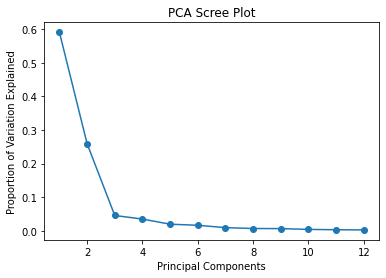

In [69]:
len_columns = len(components.columns)
x_axis = list(range(1, len_columns+1))
var_ratio = data_pca.explained_variance_ratio_ # Find the amount of variance explained by each components
plt.plot(x_axis, var_ratio, '-o')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variation Explained')
plt.show()

In [70]:
data_pcomp = data_pca.fit_transform(scaled_data)
data_pcomp = pd.DataFrame(data_pcomp)
data_pcomp = data_pcomp.iloc[:,0:11]
data_pcomp.columns = ['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5', 'Comp6', 'Comp7', 'Comp8', 'Comp9', 'Comp10', 'Comp11']
data_pcomp.head()

,Comp1,Comp2,Comp3,Comp4,Comp5,Comp6,Comp7,Comp8,Comp9,Comp10,Comp11
0,0.734939,-1.491533,-1.153781,-0.916870,-0.840017,0.178807,-0.332718,-1.248968,-0.122175,-0.104997,-0.329149
1,-0.929007,-2.065363,-0.831633,-0.615151,0.533020,0.308267,0.082327,-0.688494,0.564857,0.297745,-0.915322
2,-0.363360,-1.891213,-0.443759,0.106853,0.833943,-0.086263,0.284895,-0.727098,0.810639,-0.225875,0.155607
3,-0.672967,-0.594472,-0.924298,-0.057635,0.433050,0.058139,0.103944,-0.830002,0.062984,-0.466231,-0.063571
4,-0.803857,-1.408169,-0.608998,-0.387804,-0.038213,0.769492,-0.648413,-0.910340,0.217421,0.076414,-0.423711


In [71]:
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(scaled_df)
print(f"Number of components chosen: {pca.n_components_}")

# data_pcomp based on cumulative varaince 
data_pcomp = data_pcomp.iloc[:,0:5]
data_pcomp.head()

Number of components chosen: 5


,Comp1,Comp2,Comp3,Comp4,Comp5
0,0.734939,-1.491533,-1.153781,-0.916870,-0.840017
1,-0.929007,-2.065363,-0.831633,-0.615151,0.533020
2,-0.363360,-1.891213,-0.443759,0.106853,0.833943
3,-0.672967,-0.594472,-0.924298,-0.057635,0.433050
4,-0.803857,-1.408169,-0.608998,-0.387804,-0.038213


In [72]:
# data_pcomp2 based on scree plot (3 components)
data_pcomp2 = data_pcomp.iloc[:,0:3]
data_pcomp2.head()

,Comp1,Comp2,Comp3
0,0.734939,-1.491533,-1.153781
1,-0.929007,-2.065363,-0.831633
2,-0.363360,-1.891213,-0.443759
3,-0.672967,-0.594472,-0.924298
4,-0.803857,-1.408169,-0.608998


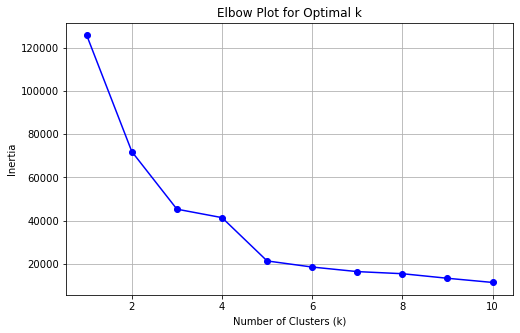

In [73]:
inertia = []


# Try k from 1 to, say, 10
K = range(1, 11)


for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)


# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Optimal k')
plt.grid(True)
plt.show()

In [97]:
kmeans = KMeans(n_clusters=4).fit(data_pcomp2)
labels_true = kmeans.labels_

In [98]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score
import numpy as np

def evaluate_kmeans_summary(X, true_labels, n_clusters, n_runs=30):
    true_labels = np.ravel(true_labels) # Ensure 1D

    ari_scores = []
    nmi_scores = []
    sil_scores = []
    inertias = []
    db_scores = []

    best_sil_score = -1
    best_run = {}

    for _ in range(n_runs):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=None)
        labels = kmeans.fit_predict(X)

        # Metrics
        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)
        sil = silhouette_score(X, labels)
        inertia = kmeans.inertia_
        db = davies_bouldin_score(X, labels)

        # Store metrics
        ari_scores.append(ari)
        nmi_scores.append(nmi)
        sil_scores.append(sil)
        inertias.append(inertia)
        db_scores.append(db)

        # Track best run by silhouette score
        if sil > best_sil_score:
            best_sil_score = sil
            best_run = {
                'labels': labels,
                'cluster_centers': kmeans.cluster_centers_,
                'cluster_sizes': np.bincount(labels),
                'inertia': inertia,
                'silhouette_score': sil,
                'davies_bouldin': db
            }

    results = {}

    # Store means and standard deviations
    results['mean_ARI'] = np.round(np.mean(ari_scores), 3)
    results['std_ARI'] = np.round(np.std(ari_scores), 3)
    results['mean_NMI'] = np.round(np.mean(nmi_scores), 3)
    results['std_NMI'] = np.round(np.std(nmi_scores), 3)
    results['mean_Silhouette'] = np.round(np.mean(sil_scores), 3)
    results['std_Silhouette'] = np.round(np.std(sil_scores), 3)
    results['mean_Inertia'] = np.round(np.mean(inertias), 2)
    results['std_Inertia'] = np.round(np.std(inertias), 2)
    results['mean_Davies_Bouldin'] = np.round(np.mean(db_scores), 2)
    results['std_Davies_Bouldin'] = np.round(np.std(db_scores), 2)

    # Best run details (shortened for readability)
    results['best_run'] = {
        'labels': best_run['labels'][:10],
        'cluster_sizes': best_run['cluster_sizes'],
        'cluster_centers': np.round(best_run['cluster_centers'], 3),
        'inertia': np.round(best_run['inertia'], 2),
        'silhouette_score': np.round(best_run['silhouette_score'], 3),
        'davies_bouldin': np.round(best_run['davies_bouldin'], 2)
    }

    return results

# Run and store the result
results = evaluate_kmeans_summary(scaled_df, labels_true, n_clusters=4, n_runs=10)

# Output
print("### K-Means++ Clustering Summary with scaled_df ###")
print("\n**Performance Metrics (Averaged Across 30 Runs):**")
print(f"Mean Inertia: {results['mean_Inertia']} ± {results['std_Inertia']}")
print(f"Mean Silhouette Score: {results['mean_Silhouette']} ± {results['std_Silhouette']}")
print(f"Mean ARI: {results['mean_ARI']} ± {results['std_ARI']}")
print(f"Mean NMI: {results['mean_NMI']} ± {results['std_NMI']}")
print(f"Mean DBI: {results['mean_Davies_Bouldin']} ± {results['std_Davies_Bouldin']}")

print("\n**Best Run (Highest Silhouette Score):**")
print(f"Cluster Labels (First 10): {results['best_run']['labels']}")
print(f"Cluster Sizes: {results['best_run']['cluster_sizes']}")
print(f"Best Inertia: {results['best_run']['inertia']}")
print(f"Best Silhouette Score: {results['best_run']['silhouette_score']}")
print(f"Best DBI Score: {results['best_run']['davies_bouldin']}")

### K-Means++ Clustering Summary with scaled_df ###

**Performance Metrics (Averaged Across 30 Runs):**
Mean Inertia: 26556.36 ± 0.0
Mean Silhouette Score: 0.741 ± 0.0
Mean ARI: 1.0 ± 0.0
Mean NMI: 1.0 ± 0.0
Mean DBI: 0.29 ± 0.0

**Best Run (Highest Silhouette Score):**
Cluster Labels (First 10): [0 0 0 0 0 0 0 0 0 0]
Cluster Sizes: [1998   39  102   21]
Best Inertia: 26556.36
Best Silhouette Score: 0.741
Best DBI Score: 0.29


In [99]:
# Run and store the result
results1 = evaluate_kmeans_summary(data_pcomp, labels_true, n_clusters=4, n_runs=10)

# Output
print("### K-Means++ Clustering Summary with data_pcomp ###")
print("\n**Performance Metrics (Averaged Across 30 Runs):**")
print(f"Mean Inertia: {results1['mean_Inertia']} ± {results1['std_Inertia']}")
print(f"Mean Silhouette Score: {results1['mean_Silhouette']} ± {results1['std_Silhouette']}")
print(f"Mean ARI: {results1['mean_ARI']} ± {results1['std_ARI']}")
print(f"Mean NMI: {results1['mean_NMI']} ± {results1['std_NMI']}")
print(f"Mean DBI: {results1['mean_Davies_Bouldin']} ± {results1['std_Davies_Bouldin']}")

print("\n**Best Run (Highest Silhouette Score):**")
print(f"Cluster Labels (First 10): {results1['best_run']['labels']}")
print(f"Cluster Sizes: {results1['best_run']['cluster_sizes']}")
print(f"Best Inertia: {results1['best_run']['inertia']}")
print(f"Best Silhouette Score: {results1['best_run']['silhouette_score']}")
print(f"Best DBI Score: {results1['best_run']['davies_bouldin']}")

### K-Means++ Clustering Summary with data_pcomp ###

**Performance Metrics (Averaged Across 30 Runs):**
Mean Inertia: 20522.82 ± 0.0
Mean Silhouette Score: 0.785 ± 0.0
Mean ARI: 1.0 ± 0.0
Mean NMI: 1.0 ± 0.0
Mean DBI: 0.27 ± 0.0

**Best Run (Highest Silhouette Score):**
Cluster Labels (First 10): [0 0 0 0 0 0 0 0 0 0]
Cluster Sizes: [1998   21  102   39]
Best Inertia: 20522.82
Best Silhouette Score: 0.785
Best DBI Score: 0.27


In [100]:
# Run and store the result
results1 = evaluate_kmeans_summary(data_pcomp2, labels_true, n_clusters=4, n_runs=10)

# Output
print("### K-Means++ Clustering Summary with data_pcomp2 ###")
print("\n**Performance Metrics (Averaged Across 30 Runs):**")
print(f"Mean Inertia: {results1['mean_Inertia']} ± {results1['std_Inertia']}")
print(f"Mean Silhouette Score: {results1['mean_Silhouette']} ± {results1['std_Silhouette']}")
print(f"Mean ARI: {results1['mean_ARI']} ± {results1['std_ARI']}")
print(f"Mean NMI: {results1['mean_NMI']} ± {results1['std_NMI']}")
print(f"Mean DBI: {results1['mean_Davies_Bouldin']} ± {results1['std_Davies_Bouldin']}")

print("\n**Best Run (Highest Silhouette Score):**")
print(f"Cluster Labels (First 10): {results1['best_run']['labels']}")
print(f"Cluster Sizes: {results1['best_run']['cluster_sizes']}")
print(f"Best Inertia: {results1['best_run']['inertia']}")
print(f"Best Silhouette Score: {results1['best_run']['silhouette_score']}")
print(f"Best DBI Score: {results1['best_run']['davies_bouldin']}")

### K-Means++ Clustering Summary with data_pcomp2 ###

**Performance Metrics (Averaged Across 30 Runs):**
Mean Inertia: 13763.89 ± 0.0
Mean Silhouette Score: 0.837 ± 0.0
Mean ARI: 1.0 ± 0.0
Mean NMI: 1.0 ± 0.0
Mean DBI: 0.23 ± 0.0

**Best Run (Highest Silhouette Score):**
Cluster Labels (First 10): [0 0 0 0 0 0 0 0 0 0]
Cluster Sizes: [1998   21  102   39]
Best Inertia: 13763.89
Best Silhouette Score: 0.837
Best DBI Score: 0.23


In [103]:
labels_t=oversampled_df["Category"]
print(labels_t)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2155    3.0
2156    3.0
2157    3.0
2158    3.0
2159    3.0
Name: Category, Length: 2160, dtype: float64


In [107]:
kmeans = KMeans(n_clusters=4).fit(data_pcomp2)
labels_true = kmeans.labels_

# Check Cluster Assignments
oversampled_df['cluster'] = labels_true
print(oversampled_df)

       Age  Sex   ALB    ALP   ALT    AST    BIL    CHE  CHOL   CREA    GGT  \
0     32.0  0.0  38.5   52.5   7.7   22.1    7.5   6.93  3.23  106.0   12.1   
1     32.0  0.0  38.5   70.3  18.0   24.7    3.9  11.17  4.80   74.0   15.6   
2     32.0  0.0  46.9   74.7  36.2   52.6    6.1   8.84  5.20   86.0   33.2   
3     32.0  0.0  43.2   52.0  30.6   22.6   18.9   7.33  4.74   80.0   33.8   
4     32.0  0.0  39.2   74.1  32.6   24.8    9.6   9.15  4.32   76.0   29.9   
...    ...  ...   ...    ...   ...    ...    ...    ...   ...    ...    ...   
2155  62.0  1.0  32.0  416.6   5.9  110.3   50.0   5.57  6.30   55.7  650.9   
2156  62.0  1.0  32.0  416.6   5.9  110.3   50.0   5.57  6.30   55.7  650.9   
2157  49.0  1.0  33.0  190.7   1.2   36.3    7.0   6.92  3.82  485.9  112.0   
2158  59.0  0.0  31.0   86.3   5.4   95.4  117.0   1.57  3.51   60.5   53.6   
2159  74.0  0.0  23.0   34.1   2.1   90.4   22.0   2.50  3.29   51.0   46.8   

      PROT  Category  cluster  
0     69.0       0.

In [108]:
# Analyze Feature Statistics Per Cluster
cluster_summary = oversampled_df.groupby('cluster').mean()
print(cluster_summary)

               Age       Sex        ALB         ALP        ALT        AST  \
cluster                                                                     
0        50.058824  0.147059  29.147059   78.507353  10.909804  75.405882   
1        47.897898  0.340841  40.796559   58.252229  36.603554  72.255405   
2        44.128205  0.512821  33.487179  164.928205   2.953846  35.958974   
3        46.000000  0.000000  35.000000  109.600000   2.300000  19.200000   

                BIL       CHE      CHOL         CREA         GGT       PROT  \
cluster                                                                       
0        183.833333  1.841176  4.072087    86.813725   93.431373  66.715889   
1         15.622122  7.797668  4.870172    74.943193   81.912462  73.742993   
2          7.974359  5.326923  4.307179   502.025641  122.425641  58.012821   
3         11.000000  7.100000  4.100000  1079.100000  105.600000  69.100000   

         Category  
cluster            
0        3.000000  
1 

In [109]:
pd.crosstab(oversampled_df['cluster'], oversampled_df['Category'])

Category,0.0,1.0,2.0,3.0
cluster,,,,
0,0,0,0,102
1,540,540,540,378
2,0,0,0,39
3,0,0,0,21


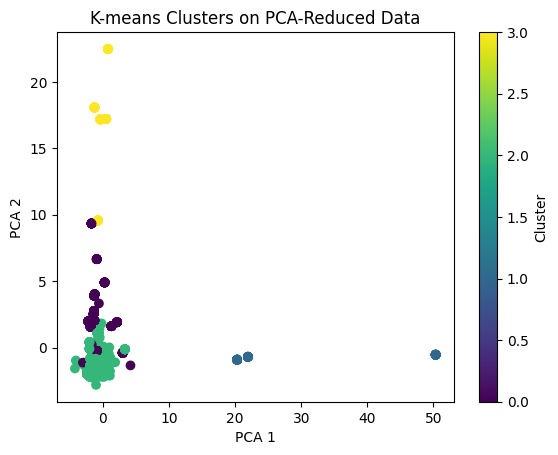

In [103]:
import matplotlib.pyplot as plt

plt.scatter(data_pcomp2.iloc[:, 0], data_pcomp2.iloc[:, 1], c=labels_true, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-means Clusters on PCA-Reduced Data')
plt.colorbar(label='Cluster')
plt.show()

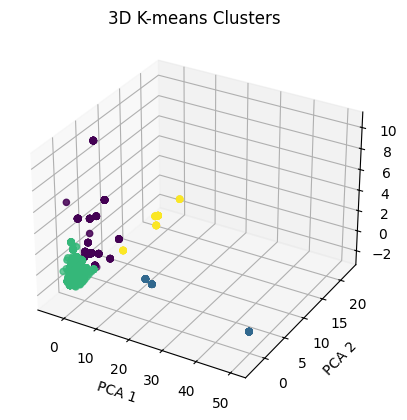

In [104]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pcomp2.iloc[:, 0], data_pcomp2.iloc[:, 1], data_pcomp2.iloc[:, 2], c=labels_true, cmap='viridis')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('3D K-means Clusters')
plt.show()

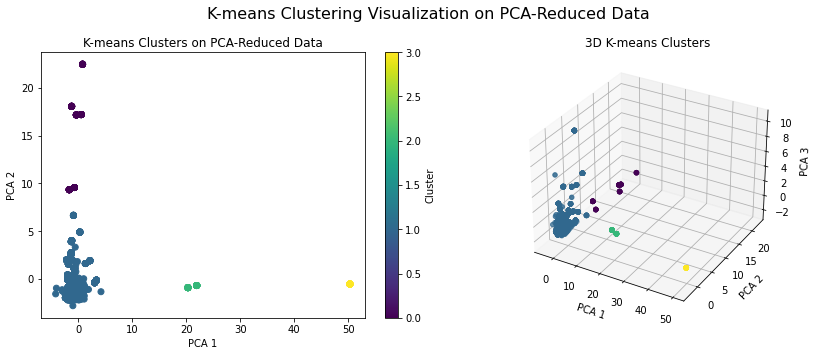

In [112]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

fig.suptitle('K-means Clustering Visualization on PCA-Reduced Data', fontsize=16)

# 2D Plot (Left)
ax1 = fig.add_subplot(1, 2, 1)
scatter = ax1.scatter(data_pcomp2.iloc[:, 0], data_pcomp2.iloc[:, 1], c=labels_true, cmap='viridis')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_title('K-means Clusters on PCA-Reduced Data')
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Cluster')

# 3D Plot (Right)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
p = ax2.scatter(data_pcomp2.iloc[:, 0], data_pcomp2.iloc[:, 1], data_pcomp2.iloc[:, 2], c=labels_true, cmap='viridis')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')
ax2.set_zlabel('PCA 3')
ax2.set_title('3D K-means Clusters')

plt.tight_layout()
plt.savefig('3d2d.png')
plt.show()


In [105]:
pca_components_df = pd.DataFrame(pca.components_, columns=['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT'])
print(pca_components_df)

        Age       Sex       ALB       ALP       ALT       AST       BIL  \
0 -0.002070 -0.004606 -0.016567  0.046820 -0.030747 -0.018521 -0.018199   
1  0.019078 -0.010674 -0.104088  0.063319 -0.056684  0.054130  0.977058   
2  0.104674  0.002789 -0.071104  0.474268  0.138757  0.260052 -0.116975   
3 -0.020359 -0.041728  0.049919 -0.193538  0.931451  0.136231  0.079875   
4 -0.180483 -0.058480  0.435429  0.066143 -0.000698 -0.350783  0.143684   

        CHE      CHOL      CREA       GGT      PROT  
0 -0.009706 -0.009235  0.997167  0.020662 -0.030642  
1 -0.121534 -0.037998  0.007906  0.074636 -0.045240  
2 -0.080284  0.004322 -0.033123  0.806581  0.018786  
3  0.019836 -0.067684  0.050505 -0.072520  0.229285  
4  0.500697  0.515839  0.013230  0.198630  0.264428  
